### Курсовой проект для курса "Python для Data Science"

**Материалы к проекту (файлы):**
train.csv
test.csv

**Задание:**
Используя данные из train.csv, построить
модель для предсказания цен на недвижимость (квартиры).
С помощью полученной модели предсказать
цены для квартир из файла test.csv.

**Целевая переменная:**
Price

**Метрика:**
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

**Подключение библиотек**

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import r2_score as r2

import scipy as sp

from matplotlib import pyplot as plt

from datetime import datetime
import random

import seaborn as sns 
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

**Объявление констант и функций**

In [2]:
TRAIN_PATH = 'train.csv'
TEST_PATH = 'test.csv'

class Preprocessor(BaseEstimator, TransformerMixin):
    
    def __init__(self, quantile = 0.75, KitchenSquare = 3):
        self.quantile = quantile
        self.min_KitchenSquare = KitchenSquare
        
    def fit(self, X, y=None):
        self.medians_for_nan = X[['LifeSquare', 'Healthcare_1']].median()
        self.median_for_outlier = X[['Rooms', 'KitchenSquare', 'HouseFloor']].median()
        self.quantile_x = X.quantile(self.quantile)
        self.quantile_KitchenSquare_125 = X['KitchenSquare'].quantile(.125)
        self.current_year = datetime.now().year
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        return self

    def transform(self, X):
        #print('transform: ', len(X))
        # 1. обработка пропусков
        x_nan = self.nan(X)
        # 2. обработка выбросов
        x_outlier = self.outlier(x_nan)
        # 3. построение новых признаков
        x_feature = self.feature(x_outlier)
        
#         return np.array(x_feature)
#         return x_feature
        return sp.sparse.bsr_matrix(np.array(x_feature))
    
    def nan(self, X):
        # LifeSquare и Healthcare_1
        X[['LifeSquare', 'Healthcare_1']] = X[['LifeSquare', 'Healthcare_1']].fillna(self.medians_for_nan)
        
        return X
    
    def outlier(self, X):
        # Rooms (количество комнат):
        # 0 - не может быть (или это м.б. одна комната - студия)
        # 10/19 тоже не м.б.
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] >= 6, 'Rooms'] = self.median_for_outlier['Rooms']
        
        # KitchenSquare (площадь кухни):
        # считаем по квантилю (значение будет указываться в конструкторе)
        # min_KitchenSquare - минимальное значение площади кухни
        X.loc[X['KitchenSquare'] >= self.quantile_x['KitchenSquare'], 'KitchenSquare'] = self.median_for_outlier['KitchenSquare']
        X.loc[X['KitchenSquare'] < self.min_KitchenSquare, 'KitchenSquare'] = self.min_KitchenSquare
                                    
        # HouseFloor
        X['HouseFloor_outlier'] = 0
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1
        
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.median_for_outlier['HouseFloor']
        
        floor_outliers = X.loc[X['Floor'] > X['HouseFloor']].index
        X.loc[floor_outliers, 'Floor'] = X.loc[floor_outliers, 'HouseFloor']\
                                            .apply(lambda x: random.randint(1, x))
                                    
        # HouseYear: не больше 2020 года
        X.loc[X['HouseYear'] > self.current_year, 'HouseYear'] = self.current_year
                                    
        return X
        
    
    def feature(self, X):
        # обработка номинативных переменных 
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
                                    
        return X

### Загрузка данных <a class='anchor' id='load'>

**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [29]:
df_train = pd.read_csv(TRAIN_PATH, sep=',')
df_train.head(10)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644
5,12915,59,3.0,80.384479,46.683720,12.0,5,17.0,2011,0.309479,B,B,35,7715,4,990.0,0,6,B,215898.447742
6,14549,154,2.0,62.254114,37.160377,7.0,3,5.0,1960,0.460556,B,B,20,4386,14,NaN,1,5,B,296021.204377
7,11993,74,2.0,80.312926,NaN,0.0,14,0.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,221244.156664
8,5172,1,2.0,64.511437,NaN,1.0,9,17.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,229102.795999
9,8649,23,1.0,46.461409,18.915552,8.0,13,17.0,2014,0.075779,B,B,6,1437,3,NaN,0,2,B,95380.220993


In [30]:
df_test = pd.read_csv(TEST_PATH, sep=',')
df_test.head(10)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
5,7633,53,1.0,40.675627,NaN,1.0,21,21.0,1977,0.049637,B,B,34,7759,0,229.0,1,3,B
6,13329,23,2.0,68.099538,64.843025,1.0,2,17.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
7,5502,32,2.0,48.193897,32.857644,6.0,5,14.0,1972,0.135650,B,B,46,7960,6,350.0,3,11,B
8,4220,96,3.0,72.277106,45.968758,9.0,17,17.0,1997,0.041116,B,B,53,14892,4,NaN,1,4,B
9,11538,6,3.0,80.219400,47.660260,9.0,13,17.0,2014,0.243205,B,B,5,1564,0,540.0,0,0,B


In [31]:
X, Y = df_train.iloc[:,:-1], df_train.iloc[:,-1]
x_train, x_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.33, shuffle=True, random_state=21)

In [32]:
# preprocessor = Preprocessor(quantile = .975, KitchenSquare = 3)
# # x_train[['LifeSquare', 'Healthcare_1']].median()
# preprocessor.fit(x_train)

# x_train = preprocessor.transform(x_train)
# # x_valid = preprocessor.transform(x_valid)
# # df_test = preprocessor.transform(df_test)

x_train.shape, x_valid.shape, df_test.shape


((6700, 19), (3300, 19), (5000, 19))

### Анализ данных

In [33]:
x_train.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,6700.000000,6700.000000,6700.000000,6700.000000,5260.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,6700.000000,3481.000000,6700.000000,6700.000000
mean,8423.356119,50.475522,1.882537,56.081497,37.415591,6.438060,8.494776,12.647463,1985.154776,0.118740,24.670597,5333.197463,7.952985,1150.579718,1.332836,4.222985
std,4853.411945,43.509927,0.815633,20.468093,104.661936,34.688095,5.220311,6.803397,40.872731,0.119600,17.459441,3977.675264,23.718438,1021.277009,1.510859,4.812391
min,0.000000,0.000000,0.000000,1.988943,0.370619,0.000000,1.000000,0.000000,1912.000000,0.000000,0.000000,168.000000,0.000000,30.000000,0.000000,0.000000
25%,4241.750000,20.000000,1.000000,41.798893,22.711308,1.000000,4.000000,9.000000,1973.000000,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000
50%,8427.500000,35.000000,2.000000,52.083642,32.505331,6.000000,7.000000,13.000000,1977.000000,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000
75%,12653.250000,75.250000,2.000000,65.790145,44.768302,9.000000,12.000000,17.000000,2001.000000,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000
max,16798.000000,209.000000,10.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,4968.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000


**Rooms**

In [36]:
Rooms = df_train['Rooms'].value_counts()
pd.DataFrame(Rooms)

,Rooms
2.0,3880
1.0,3705
3.0,2235
4.0,150
5.0,18
0.0,8
10.0,2
19.0,1
6.0,1


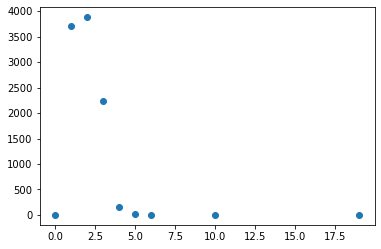

In [37]:
plt.scatter(np.array(Rooms.index), np.array(Rooms))

<AxesSubplot:ylabel='Rooms'>

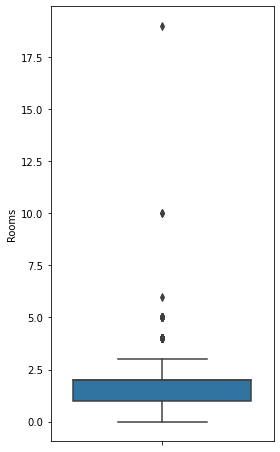

In [39]:
plt.figure(figsize = (4,8))
sns.boxplot(y = df_train['Rooms'])

**KitchenSquare**

In [40]:
KitchenSquare = df_train['KitchenSquare'].value_counts()
pd.DataFrame(KitchenSquare).sort_index()

,KitchenSquare
0.0,697
1.0,2460
2.0,4
3.0,22
4.0,39
5.0,1169
6.0,1038
7.0,609
8.0,1306
9.0,843


13.0

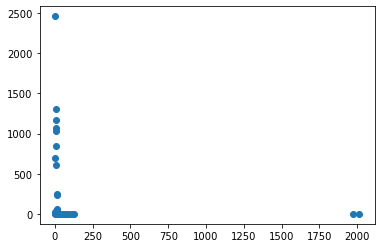

In [52]:
plt.scatter(np.array(KitchenSquare.index), np.array(KitchenSquare))
# по графику видно, что площадь кухни после больше 200 не стоит рассматривать
df_train['KitchenSquare'].quantile(0.975)

(0.0, 20.0, 0.0, 2500.0)

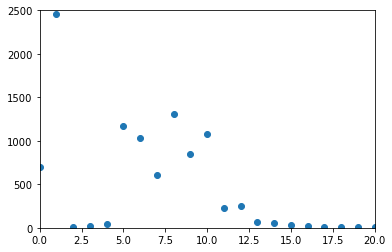

In [56]:
plt.scatter(np.array(KitchenSquare.index), np.array(KitchenSquare))
plt.axis([0, 20, 0, 2500])
# начиная с 13 значения = 1 и с помощью квантиля (0.975) можно обработать данные

**HouseYear**

In [59]:
HouseYear = x_train['HouseYear'].value_counts()
pd.DataFrame(HouseYear).sort_index()

# по данному признаку видно, что существует год больше чем 2020 => их нужно обработать

,HouseYear
1912,2
1914,1
1916,1
1917,2
1918,5
...,...
2017,192
2018,118
2019,51
2020,13


### Построение модели

In [7]:
classifier = RandomForestRegressor()
pipe = Pipeline([
            ('preprocessor', Preprocessor(quantile = .975, KitchenSquare=4)),
            ('to_dense', FunctionTransformer(lambda x: x.todense(), accept_sparse=True)),
            ('classifier', classifier)])


search_space = [
    {
        'classifier': [DecisionTreeRegressor()],
        'preprocessor': [Preprocessor(quantile = .975, KitchenSquare=3),
                        Preprocessor(quantile = .75, KitchenSquare=3),
                        Preprocessor(quantile = .975, KitchenSquare=4)],
        'classifier__criterion': ['mse'],
        'classifier__max_depth': [20],
        'classifier__min_samples_leaf': [30],
        'classifier__random_state': [42],
    },
    {
        'classifier': [GradientBoostingRegressor()],
        'preprocessor': [Preprocessor(quantile = .975, KitchenSquare=3),
                        Preprocessor(quantile = .75, KitchenSquare=3),
                        Preprocessor(quantile = .975, KitchenSquare=4)],
        'classifier__random_state': [42],
        'classifier__criterion': ['mse'],
        'classifier__max_depth': [7],
        'classifier__min_samples_leaf': [10],
        'classifier__n_estimators': [100]
    },
    {
        'classifier': [LinearRegression()],
        'preprocessor': [Preprocessor(quantile = .975, KitchenSquare=3),
                        Preprocessor(quantile = .75, KitchenSquare=3),
                        Preprocessor(quantile = .975, KitchenSquare=4)],
    },
    {
        'classifier': [RandomForestRegressor()],
        'preprocessor': [Preprocessor(quantile = .975, KitchenSquare=3),
                        Preprocessor(quantile = .75, KitchenSquare=3),
                        Preprocessor(quantile = .975, KitchenSquare=4)],
        'classifier__random_state': [21],
        'classifier__criterion': ['mse']
    }
]

In [8]:
clf = GridSearchCV(pipe, search_space, scoring='r2', verbose=0, cv=3)
best_model = clf.fit(x_train, y_train)

In [9]:
target_pred = best_model.best_estimator_.predict(x_valid)
print('Score: ', r2(y_valid, target_pred))

Score:  0.732635332289422


In [10]:
print('------------- Parameters  -------------')
print(best_model.best_estimator_.get_params()['classifier'])
print(best_model.best_estimator_.get_params()['preprocessor'])

------------- Parameters  -------------
GradientBoostingRegressor(criterion='mse', max_depth=7, min_samples_leaf=10,
                          random_state=42)
Preprocessor(KitchenSquare=None, quantile=0.975)


In [12]:
predictions = best_model.best_estimator_.predict(df_test)
predictions

array([151191.88173727, 194698.42538532, 265059.9419675 , ...,
       330900.54594548, 204545.16123707, 173796.99315608])

In [14]:
with open('results.csv', 'w') as fp:
    fp.write('Price\n')
    for pred in predictions:
        fp.write(f'{pred}\n')